# 5. Explore sites/PFI data

Check quickly to see if there's anything relevant in the PFI/site data. This data has a column called "Medical records (m2)" which records the total floor area dedicated to medical records storage.

It looks like there's a weakish positive correlation between floor area and total medical records spending, as you'd expect. The presence or absence of PFI sites doesn't appear make a huge difference. However, the correlation between floor area and spending is lower among trusts with PFI sites - 0.4 as opposed to 0.7, which might bear further investigation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.ticker import StrMethodFormatter

## Import sites and PFI files

Import the site/PFI data from the ERIC dataset and group it up by trust.

In [2]:
cols = ['Trust Code', 'Trust Name', 'Site Code', 'Site Name', 'Site Type', 'Medical records (m2)']

In [3]:
df_sites = pd.read_csv("./data/source/eric/ERIC---202324---Site-data---Provisional.csv")
df_sites['mr2'] = df_sites['Medical records (m2)'].str.replace(",", "").str.replace("Not Applicable", "0").astype(int)
df_sites.head()[cols]

,Trust Code,Trust Name,Site Code,Site Name,Site Type,Medical records (m2)
0,R0A,MANCHESTER UNIVERSITY NHS FOUNDATION TRUST,C5Y2X,LANCE BURN HEALTH CENTRE,Non inpatient,0
1,R0A,MANCHESTER UNIVERSITY NHS FOUNDATION TRUST,C9Y7X,CRESCENT BANK,Non inpatient,0
2,R0A,MANCHESTER UNIVERSITY NHS FOUNDATION TRUST,E4D1L,WYTHENSHAWE OFFICES,Non inpatient,0
3,R0A,MANCHESTER UNIVERSITY NHS FOUNDATION TRUST,H4S9Q-X,MLCO VIRTUAL WARD,Non inpatient,0
4,R0A,MANCHESTER UNIVERSITY NHS FOUNDATION TRUST,I0Z5L,"MEDICAL RECORD 2, ASHBURY'S BUSINESS CENTRE",Non inpatient,618


In [4]:
site_area_by_trust = df_sites.groupby("Trust Code").sum()['mr2'].reset_index()
site_area_by_trust.rename(columns={"mr2": "site_medical_records_m2"}, inplace=True)
site_area_by_trust

,Trust Code,site_medical_records_m2
0,R0A,3381
1,R0B,3351
2,R0D,805
3,R1A,366
4,R1C,74
...,...,...
204,RYY,108
205,TAD,65
206,TAF,0
207,TAH,0


In [5]:
df_pfi = pd.read_csv("./data/source/eric/ERIC---202324---PFI-data---Provisional.csv")
df_pfi['mr2'] = df_sites['Medical records (m2)'].str.replace(",", "").str.replace("Not Applicable", "0").astype(int)
df_pfi.head()[cols]

,Trust Code,Trust Name,Site Code,Site Name,Site Type,Medical records (m2)
0,R0A,MANCHESTER UNIVERSITY NHS FOUNDATION TRUST,R0A01,ISLAND SITE,General acute hospital,543
1,R0A,MANCHESTER UNIVERSITY NHS FOUNDATION TRUST,R0A07,WYTHENSHAWE HOSPITAL,General acute hospital,435
2,R1H,BARTS HEALTH NHS TRUST,R1H12,THE ROYAL LONDON,General acute hospital,162
3,R1H,BARTS HEALTH NHS TRUST,R1HM0,ST BATHOLOMEWS HOSPITAL,Specialist hospital (acute only),0
4,R1H,BARTS HEALTH NHS TRUST,R1HNH,NEWHAM GENERAL HOSPITAL,General acute hospital,0


In [6]:
pfi_area_by_trust = df_pfi.groupby("Trust Code").sum()['mr2'].reset_index()
pfi_area_by_trust.rename(columns={"mr2": "pfi_medical_records_m2"}, inplace=True)
pfi_area_by_trust

,Trust Code,pfi_medical_records_m2
0,R0A,0
1,R1H,618
2,R1K,1419
3,R1L,543
4,RA9,435
...,...,...
77,RXR,553
78,RXT,3626
79,RXY,257
80,RYR,0


In [7]:
df_merged = pd.merge(pfi_area_by_trust, site_area_by_trust, on='Trust Code', how="outer")
df_merged.pfi_medical_records_m2 = df_merged.pfi_medical_records_m2.fillna(0).astype(int)
# TODO - this assumes there's no double-counting, i.e. none of the PFI records are in the site records
# I think from the docs that this is true, but double-check.
df_merged['total_medical_records_m2'] = df_merged.pfi_medical_records_m2 + df_merged.site_medical_records_m2
df_merged['proportion_of_m2_pfi'] = df_merged.pfi_medical_records_m2 / df_merged.total_medical_records_m2 * 100
df_merged['has_pfi'] = df_merged.pfi_medical_records_m2 > 0
df_merged.head(10)

,Trust Code,pfi_medical_records_m2,site_medical_records_m2,total_medical_records_m2,proportion_of_m2_pfi,has_pfi
0,R0A,0,3381,3381,0.000000,False
1,R0B,0,3351,3351,0.000000,False
2,R0D,0,805,805,0.000000,False
3,R1A,0,366,366,0.000000,False
4,R1C,0,74,74,0.000000,False
5,R1D,0,441,441,0.000000,False
6,R1F,0,1231,1231,0.000000,False
7,R1H,618,1259,1877,32.924880,True
8,R1K,1419,3187,4606,30.807642,True
9,R1L,543,1072,1615,33.622291,True


## Check if floor area appears to correlate with total MRC spending

Now merge this with trust spending data, and look for any correlations. In particular, does PFI make a difference?

It looks as though there's a weak correlation between total site floor area and total spending, as you'd expect: but no particular correlation with the presence or absence of PFI sites. 

In [8]:
# Merge with our general list of sites.
df = pd.read_csv("./data/output/trust_mrc_and_epr.csv")
df.head()
df_all = pd.merge(df_merged, df, left_on='Trust Code', right_on='trust_code', how='outer')

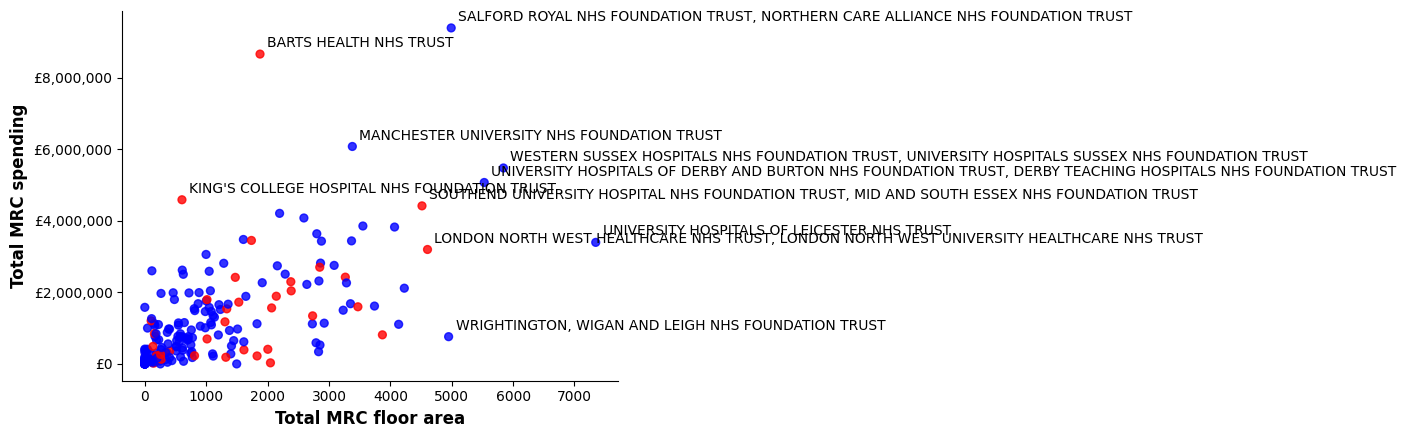

In [9]:
# Colour the scatter points by PFI status: trusts that use PFI sites are red.
scatter = df_all.plot(kind='scatter', 
                 x='total_medical_records_m2', 
                 y='mrc_total_202324', 
                 c=np.where(df_all['has_pfi'], 'red', 'blue'),
                 s=32, 
                 alpha=.8)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('£{x:,.0f}'))

# Label the outliers.
x_threshold = df_all['total_medical_records_m2'].quantile(0.97)
y_threshold = df_all['mrc_total_202324'].quantile(0.97)
for idx, row in df_all.iterrows():
    if (row['total_medical_records_m2'] > x_threshold) or (row['mrc_total_202324'] > y_threshold):
        plt.annotate(row['trust_name'], (row['total_medical_records_m2'], row['mrc_total_202324']), xytext=(5, 5), textcoords='offset points')

plt.xlabel('Total MRC floor area', fontsize=12, fontweight='bold')
plt.ylabel('Total MRC spending', fontsize=12, fontweight='bold')
plt.show()

In [10]:
pearson_corr = df_all['total_medical_records_m2'].corr(df_all['mrc_total_202324'])
spearman_corr = df_all['total_medical_records_m2'].corr(df_all['mrc_total_202324'], method='spearman')

print(f"Pearson correlation: {pearson_corr:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}")

Pearson correlation: 0.648
Spearman correlation: 0.723


Note that there is a much stronger correlation between medical records costs and floor area for non-PFI sites than for PFI sites. 

In [11]:
correlations = {
    group: df['total_medical_records_m2'].corr(df['mrc_total_202324'])
    for group, df in df_all.groupby('has_pfi')
}

print("\nCorrelations by presence/absence of PFI sites:")
for has_pfi, corr in correlations.items():
    print(f"{'PFI' if has_pfi else 'Non-PFI'}: {corr:.3f}")


Correlations by presence/absence of PFI sites:
Non-PFI: 0.706
PFI: 0.411
